C:\Users\patel\AppData\Local\Temp\ipykernel_28880\1634551369.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Loading datasets...
Cleaning text...
Extracting features...
Balancing data...
Defining models...
Tuning models...
Tuning logistic...
Best Params for logistic: {'C': 10}
Tuning random_forest...
Best Params for random_forest: {'n_estimators': 200}
Tuning svm...
Best Params for svm: {'C': 1}
Building ensemble...
Evaluating model...

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



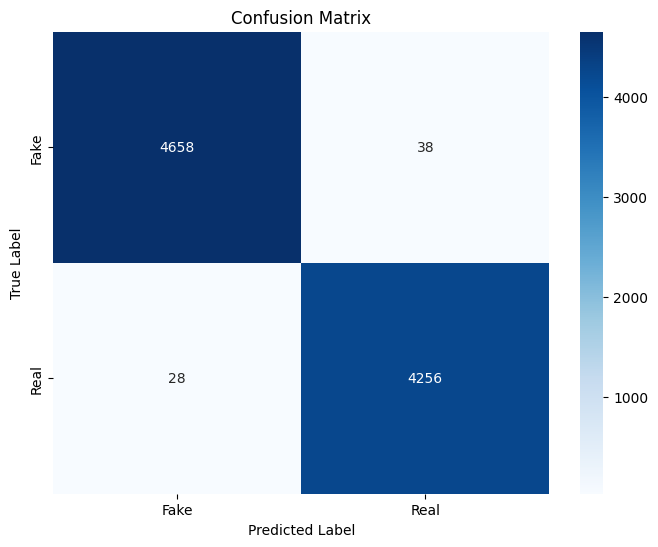

Final Model Accuracy: 0.993
Model saved to: fake_news_detector_20241124_221416.joblib


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# Step 1: Load Datasets
def load_datasets(fake_news_path, true_news_path):
    """Load fake and true news datasets, assign labels, and merge."""
    fake_news = pd.read_csv(r'C:\Users\patel\OneDrive\Desktop\Capstone Project\Capstone\fake.csv')
    true_news = pd.read_csv(r'C:\Users\patel\OneDrive\Desktop\Capstone Project\Capstone\true.csv')

    # Assign labels
    fake_news['label'] = 0
    true_news['label'] = 1

    # Combine datasets
    combined_df = pd.concat([fake_news, true_news], ignore_index=True)
    return combined_df

# Step 2: Preprocess Text
def clean_text(text):
    """Clean and preprocess the text."""
    if isinstance(text, float):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs, emails, and special characters
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization, stopword removal, and lemmatization
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

# Step 3: Extract Features
def extract_features(X_train, X_test):
    """Transform text into TF-IDF features."""
    vectorizer = TfidfVectorizer(
        max_features=10000, ngram_range=(1, 3), stop_words='english', strip_accents='unicode'
    )
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf, vectorizer

# Step 4: Balance Data
def balance_data(X_train, y_train):
    """Balance the dataset using SMOTE."""
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# Step 5: Define Models
def define_models():
    """Define base models for the ensemble."""
    models = {
        'logistic': LogisticRegression(max_iter=1000, C=1.0),
        'naive_bayes': MultinomialNB(),
        'random_forest': RandomForestClassifier(n_estimators=200),
        'svm': LinearSVC(max_iter=2000)
    }
    return models

# Step 6: Tune Hyperparameters
def tune_hyperparameters(models, X_train, y_train):
    """Tune model hyperparameters using GridSearchCV."""
    tuned_models = {}
    for name, model in models.items():
        if name == 'logistic':
            param_grid = {'C': [0.1, 1, 10]}
        elif name == 'random_forest':
            param_grid = {'n_estimators': [100, 200, 300]}
        elif name == 'svm':
            param_grid = {'C': [0.1, 1, 10]}
        else:
            tuned_models[name] = model
            continue

        print(f"Tuning {name}...")
        grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=3)
        grid_search.fit(X_train, y_train)
        tuned_models[name] = grid_search.best_estimator_
        print(f"Best Params for {name}: {grid_search.best_params_}")
    return tuned_models

# Step 7: Build Ensemble
def build_ensemble(models):
    """Build an ensemble voting classifier."""
    ensemble = VotingClassifier(
        estimators=[
            ('lr', models['logistic']),
            ('nb', models['naive_bayes']),
            ('rf', models['random_forest']),
        ],
        voting='soft'
    )
    return ensemble

# Step 8: Evaluate Model
def evaluate_model(model, X_test, y_test):
    """Evaluate the model and display results."""
    y_pred = model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return model.score(X_test, y_test)

# Step 9: Save and Load Model
def save_model(model, vectorizer, filename):
    """Save the model and vectorizer to disk."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filepath = f"{filename}_{timestamp}.joblib"
    joblib.dump({'model': model, 'vectorizer': vectorizer}, filepath)
    print(f"Model saved to: {filepath}")

def load_model(filepath):
    """Load the model and vectorizer from disk."""
    return joblib.load(filepath)

# Main Function
def main():
    # Load datasets
    print("Loading datasets...")
    combined_df = load_datasets('fake_news_data.csv', 'true_news_data.csv')

    # Preprocess data
    print("Cleaning text...")
    combined_df['cleaned_text'] = combined_df['text'].apply(clean_text)
    X = combined_df['cleaned_text']
    y = combined_df['label']

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Extract features
    print("Extracting features...")
    X_train_tfidf, X_test_tfidf, vectorizer = extract_features(X_train, X_test)

    # Balance data
    print("Balancing data...")
    X_train_balanced, y_train_balanced = balance_data(X_train_tfidf, y_train)

    # Define and tune models
    print("Defining models...")
    models = define_models()
    print("Tuning models...")
    models = tune_hyperparameters(models, X_train_balanced, y_train_balanced)

    # Build ensemble
    print("Building ensemble...")
    ensemble = build_ensemble(models)
    ensemble.fit(X_train_balanced, y_train_balanced)

    # Evaluate
    print("Evaluating model...")
    accuracy = evaluate_model(ensemble, X_test_tfidf, y_test)
    print(f"Final Model Accuracy: {accuracy:.3f}")

    # Save the model
    save_model(ensemble, vectorizer, 'fake_news_detector')

if __name__ == "__main__":
    main()


In [ ]:
import nltk

# Download all necessary NLTK resources
nltk_resources = [
    'punkt',          # Tokenization
    'stopwords',      # Stop words list
    'wordnet',        # Lemmatization
    'punkt_tab',      # Additional tokenization support
    'averaged_perceptron_tagger',  # Part-of-speech tagging
    'averaged_perceptron_tagger_eng'  # English POS tagging
]

for resource in nltk_resources:
    try:
        nltk.download(resource, quiet=True)
    except Exception as e:
        print(f"Could not download {resource}: {e}")

In [ ]:
import joblib
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def verify_model_and_resources(model_path):
    print("🔍 Starting Model and Resource Verification...")

    # Verify NLTK Resources
    try:
        stopwords.words('english')
        word_tokenize("test sentence")
        lemmatizer = WordNetLemmatizer()
        lemmatizer.lemmatize("running")
        print("✅ NLTK Resources: Successfully Loaded")
    except Exception as e:
        print(f"❌ NLTK Resource Error: {e}")
        return False

    # Verify Model Loading
    try:
        loaded_data = joblib.load(model_path)
        model = loaded_data['model']
        vectorizer = loaded_data['vectorizer']
        print("✅ Model Successfully Loaded")
    except Exception as e:
        print(f"❌ Model Loading Error: {e}")
        return False

    # Model Prediction Test
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()

        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
        return ' '.join(tokens)

    # Test prediction on a sample text
    try:
        sample_text = "This is a sample news article for testing the fake news detector."
        cleaned_text = clean_text(sample_text)
        text_vectorized = vectorizer.transform([cleaned_text])
        prediction = model.predict(text_vectorized)[0]
        probabilities = model.predict_proba(text_vectorized)[0]

        print("\n📊 Prediction Test Results:")
        print(f"Prediction: {'Real News' if prediction == 1 else 'Fake News'}")
        print(f"Probabilities: Fake={probabilities[0]:.2%}, Real={probabilities[1]:.2%}")

        return True
    except Exception as e:
        print(f"❌ Prediction Test Error: {e}")
        return False

def main():
    MODEL_PATH = r'C:\Users\patel\Downloads\fake_news_detector_20241124_221416.joblib'
    verification_result = verify_model_and_resources(MODEL_PATH)

    if verification_result:
        print("\n🎉 All Checks Passed! Model is Ready to Use.")
    else:
        print("\n❗ Some Verification Steps Failed. Please check your setup.")

if __name__ == "__main__":
    main()

🔍 Starting Model and Resource Verification...
✅ NLTK Resources: Successfully Loaded
✅ Model Successfully Loaded

📊 Prediction Test Results:
Prediction: Fake News
Probabilities: Fake=95.11%, Real=4.89%

🎉 All Checks Passed! Model is Ready to Use.
